# Import des librairies

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Chargement des données

In [2]:
# Ajouter le chemin du projet au PATH
sys.path.append(os.path.abspath(".."))
from modules.data_import import loadAndMergeData, exportDataCSV, loadInTime, loadOutTime

# Charger les données
generalData = loadAndMergeData()
inTime = loadInTime()
outTime = loadOutTime()

# Visualisation des données

In [3]:
generalData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

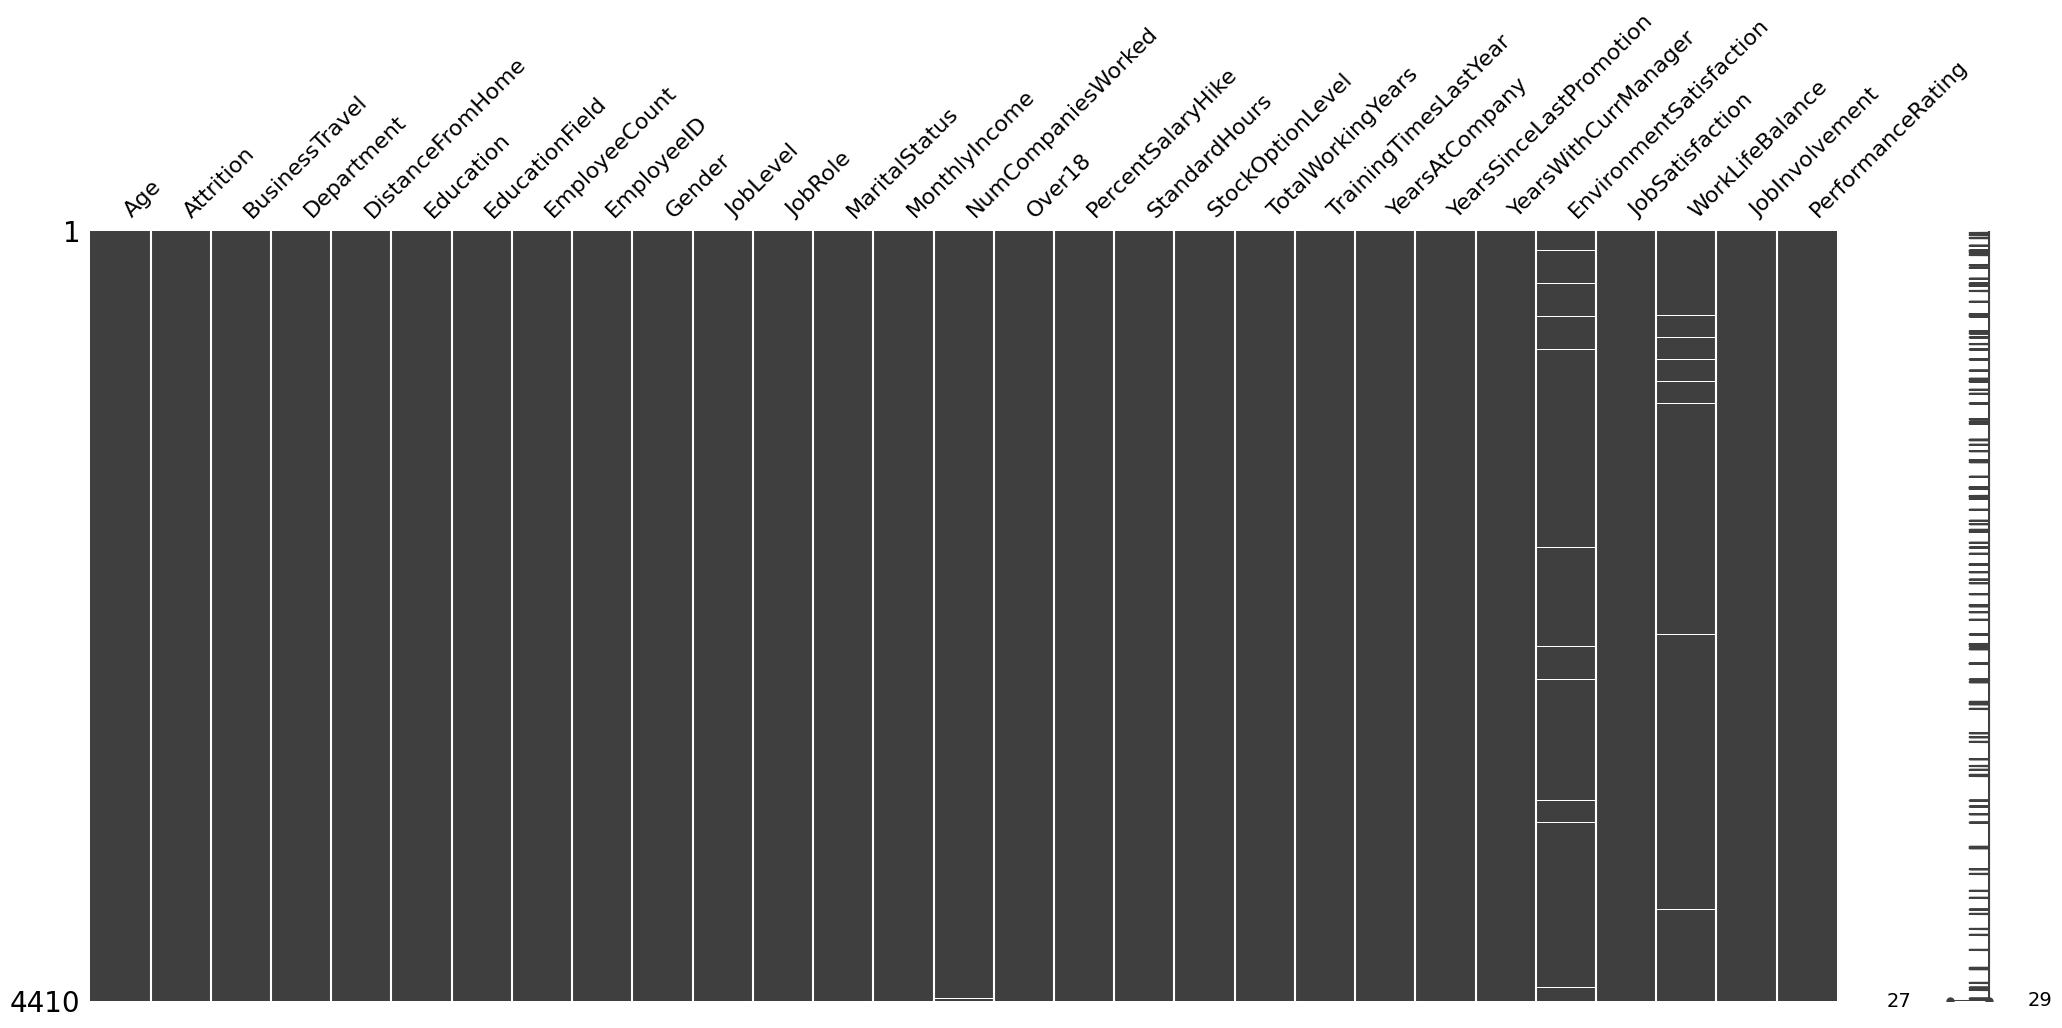

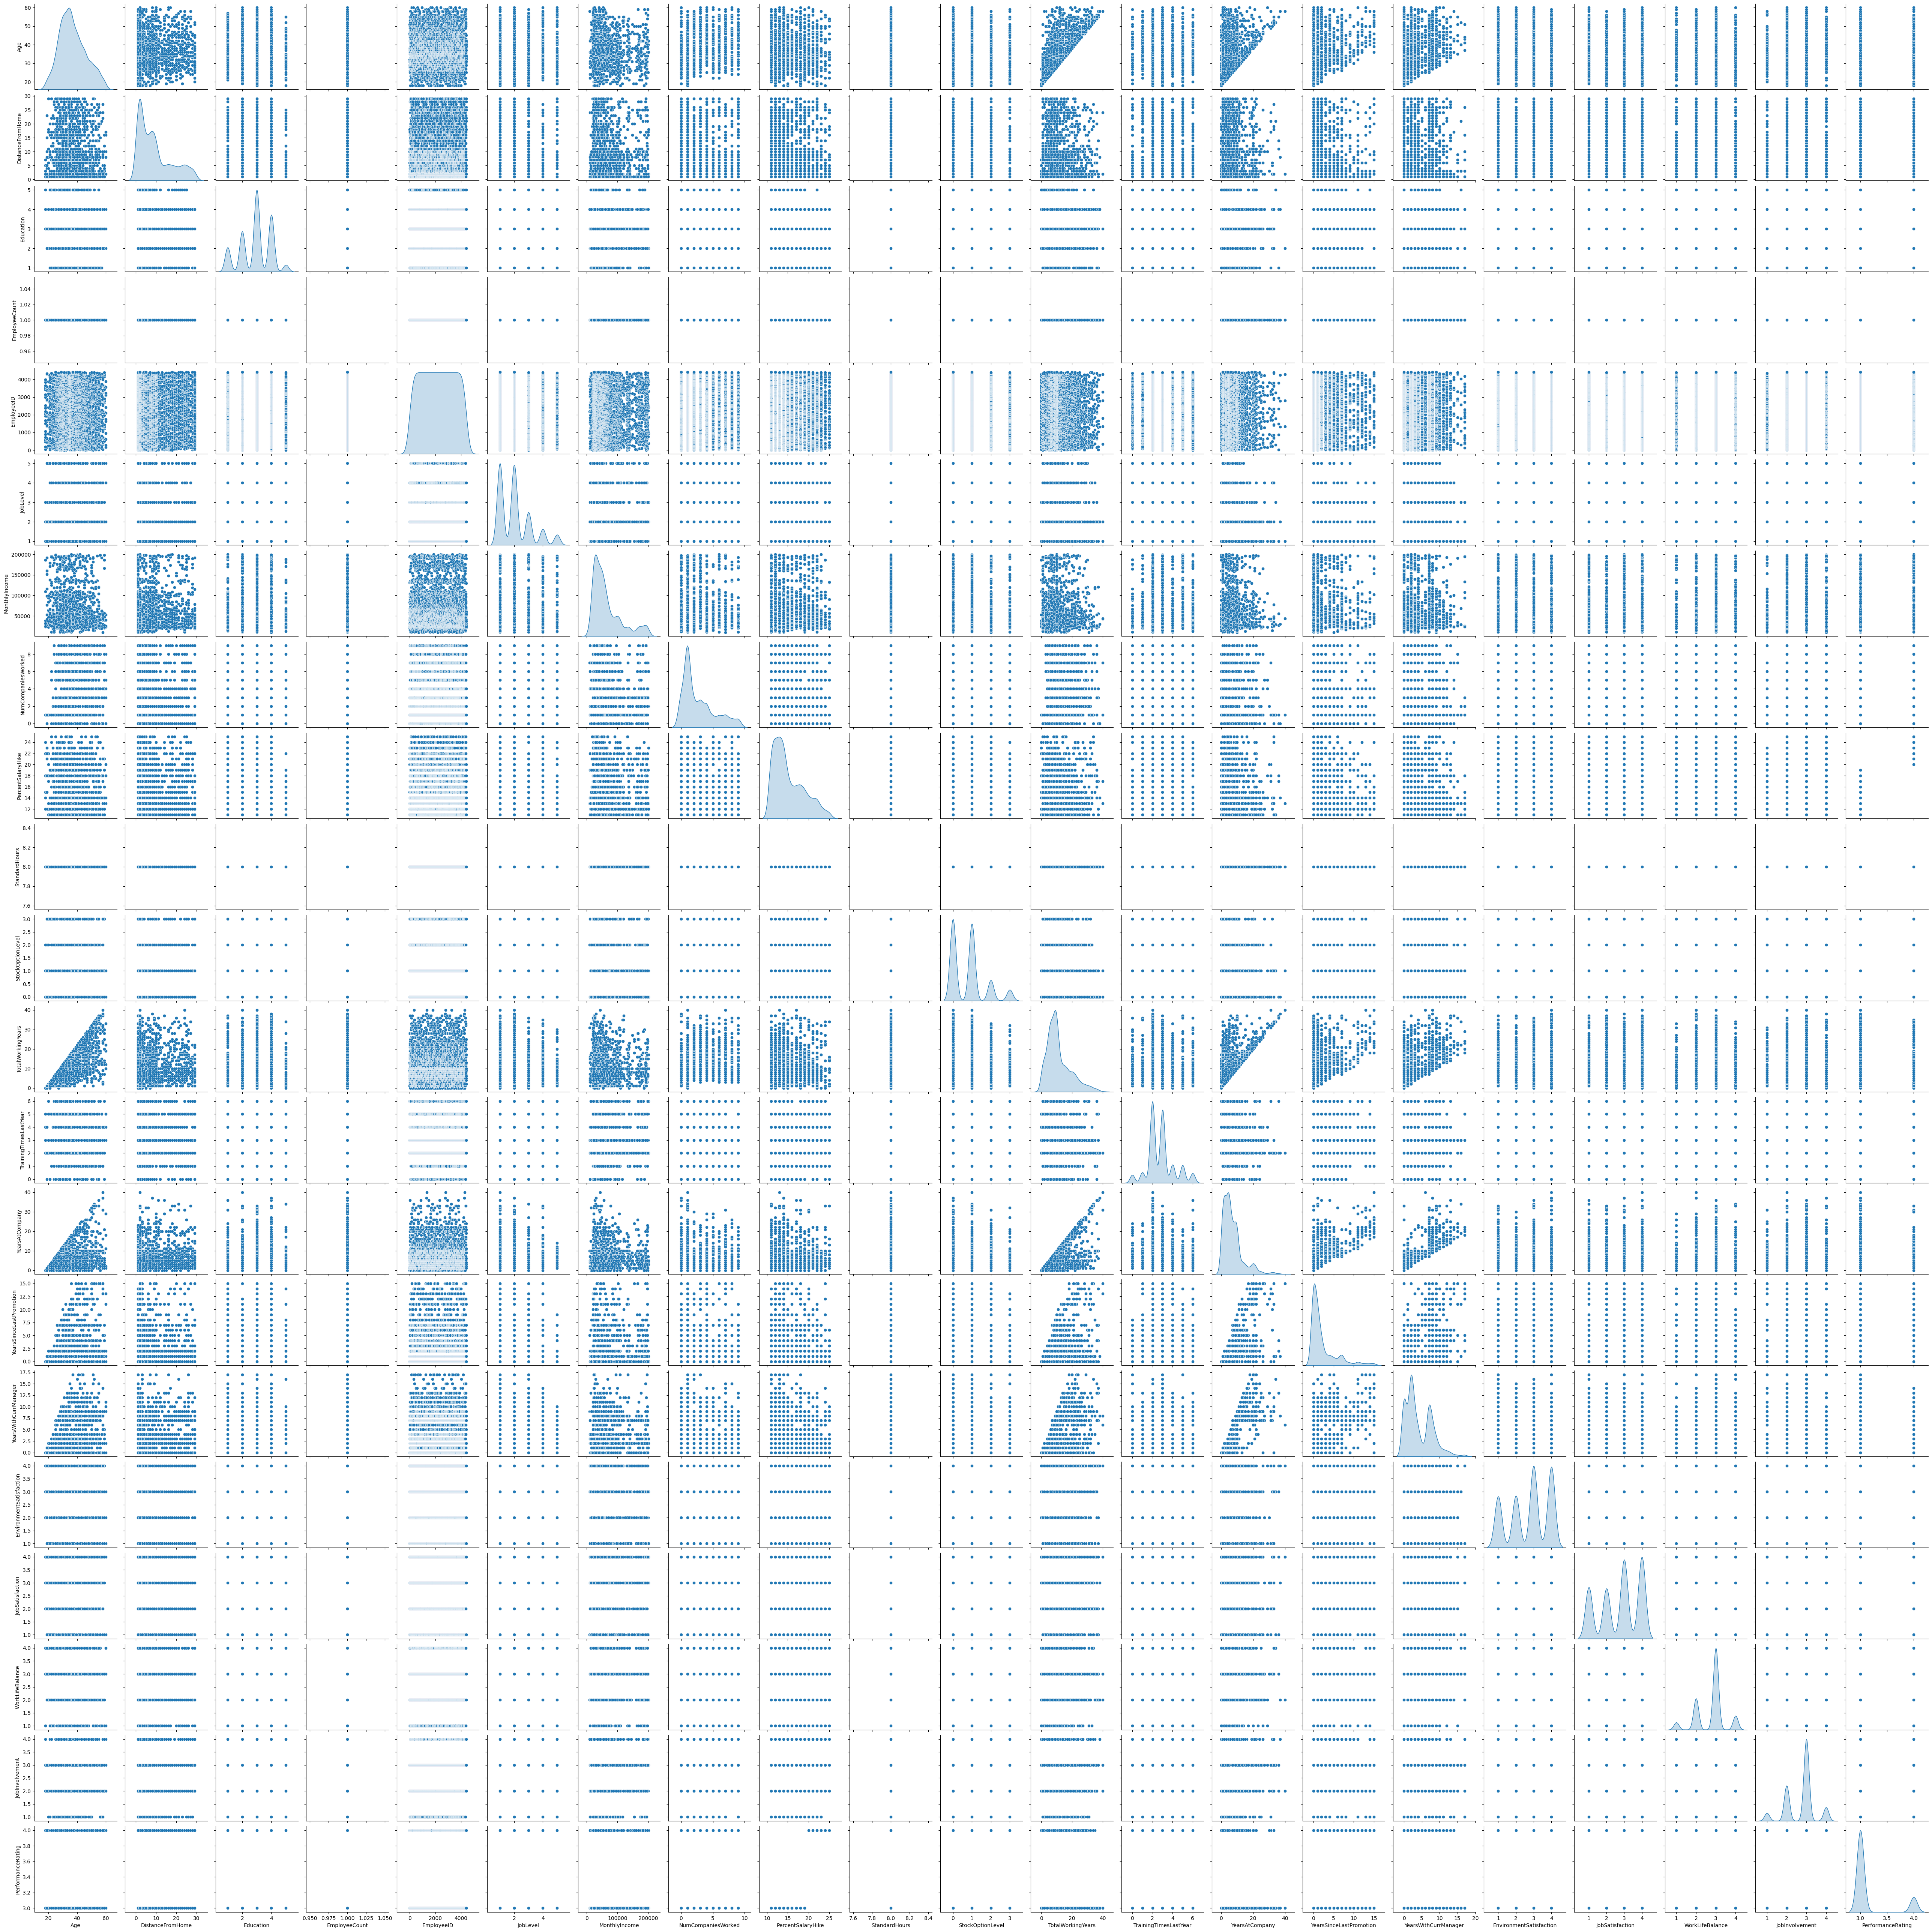

In [4]:
# Visualize missing data
msno.matrix(generalData)
plt.show()
sns.pairplot(generalData, diag_kind='kde')
plt.show()

# Remplacement des données manquantes

In [5]:
# Pour les colonnes numérique
numerical_columns = generalData.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_columns:
    if col == "TotalWorkingYears":
        # Remplacer les NA dans 'TotalWorkingYears' par la valeur de 'YearsAtCompany'
        generalData[col] = generalData[col].fillna(generalData["YearsAtCompany"])
    else:
        # Remplacer les NA pour les autres colonnes numériques par leur médiane
        generalData[col] = generalData[col].fillna(generalData[col].median())
        
# Pour les colonnes catégoriques, remplacer les NA par le mode
categorical_columns = generalData.select_dtypes(include=['object']).columns
generalData[categorical_columns] = generalData[categorical_columns].fillna(generalData[categorical_columns].mode().iloc[0])

In [6]:
generalData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

# Analyse Univariable

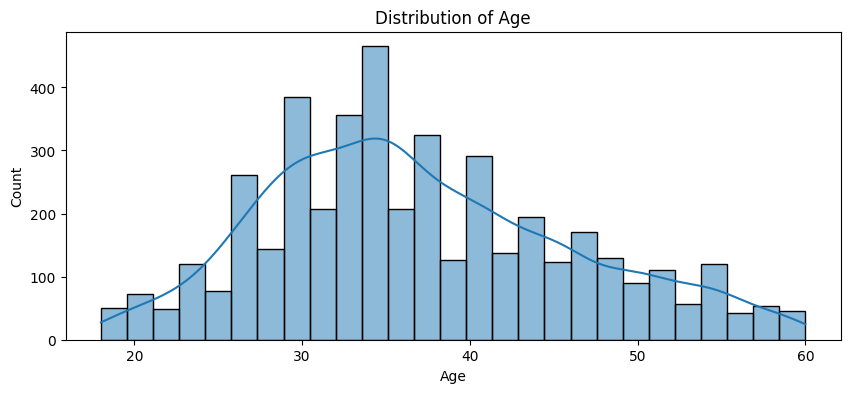

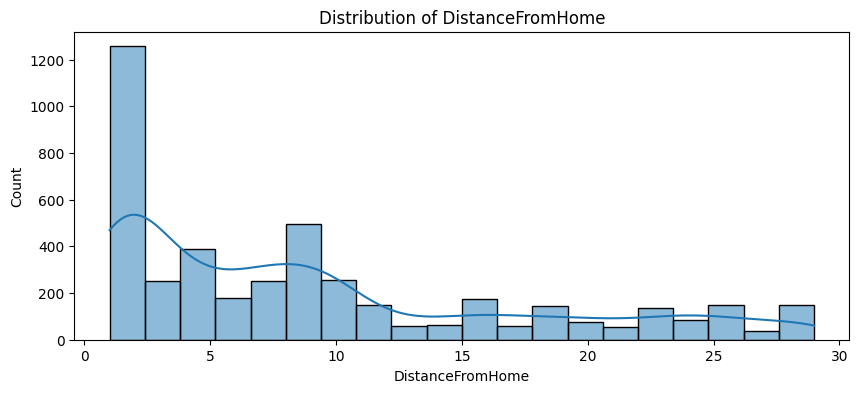

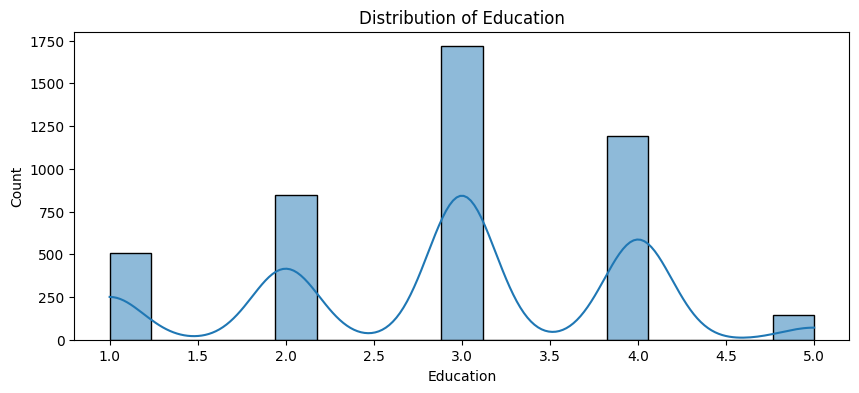

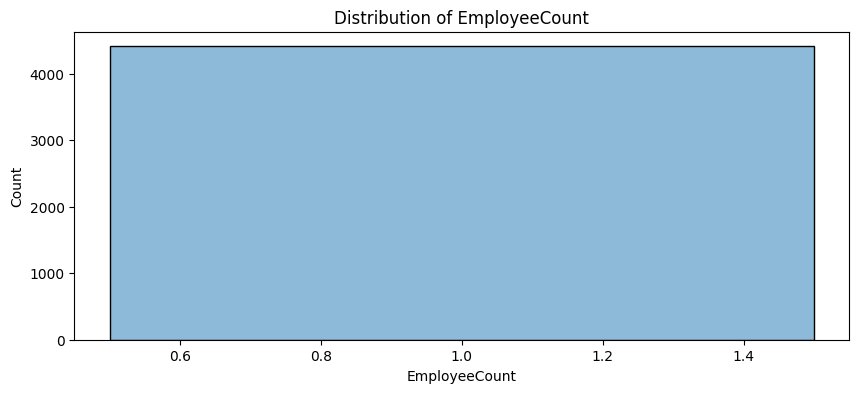

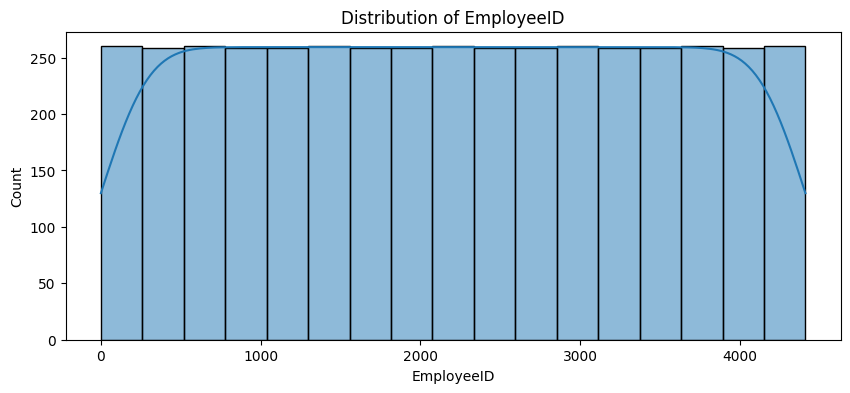

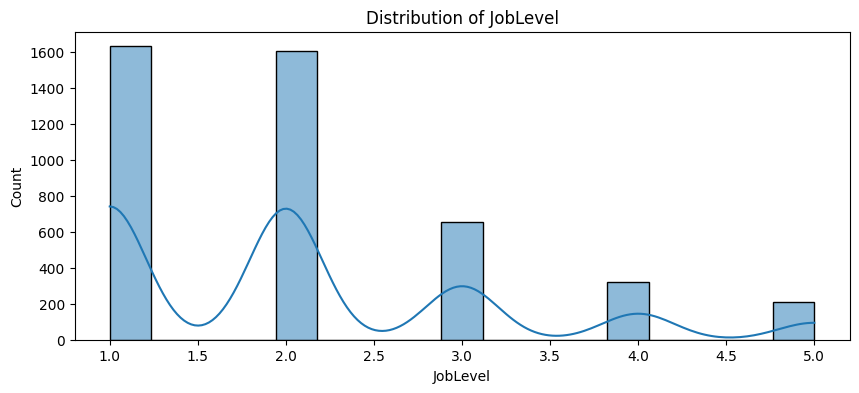

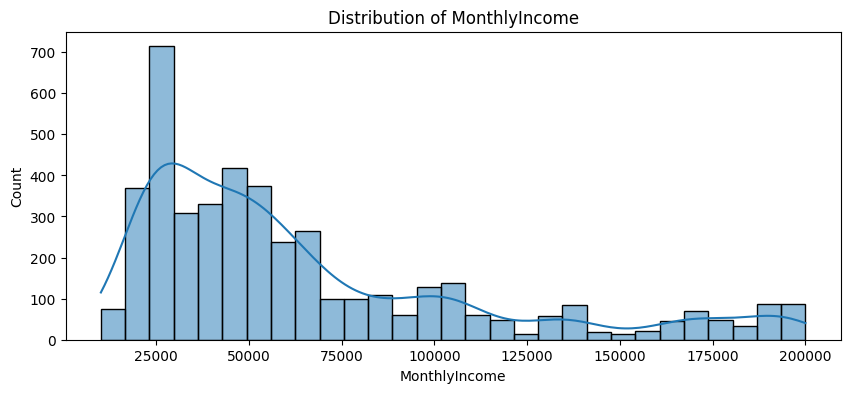

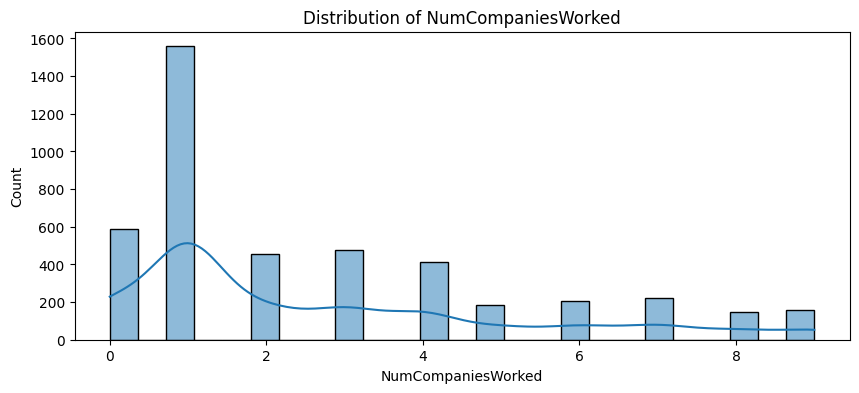

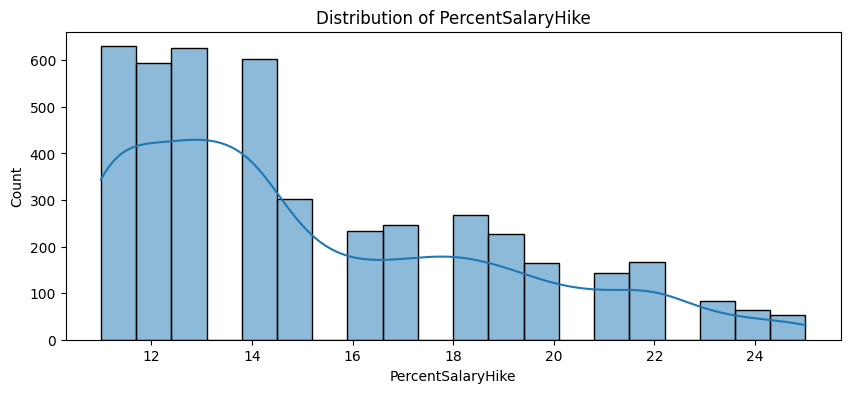

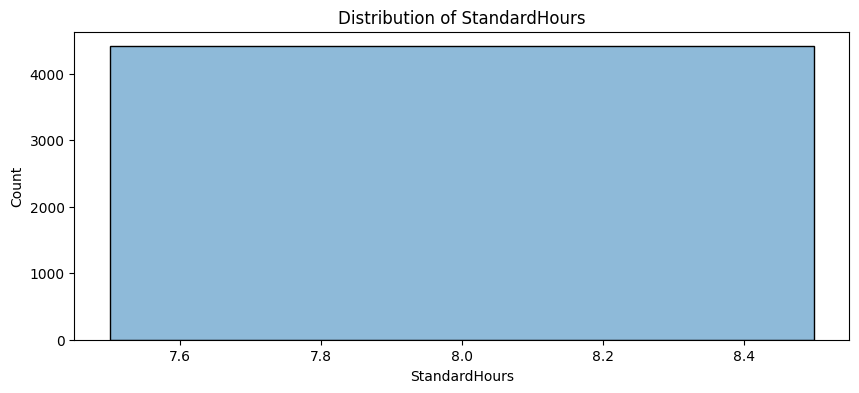

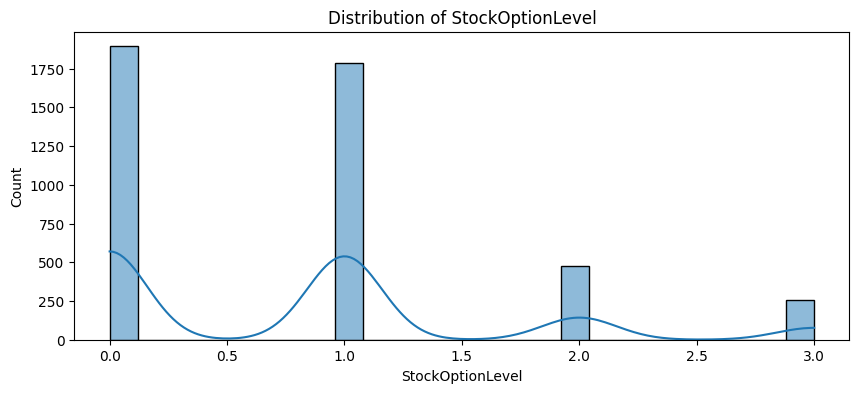

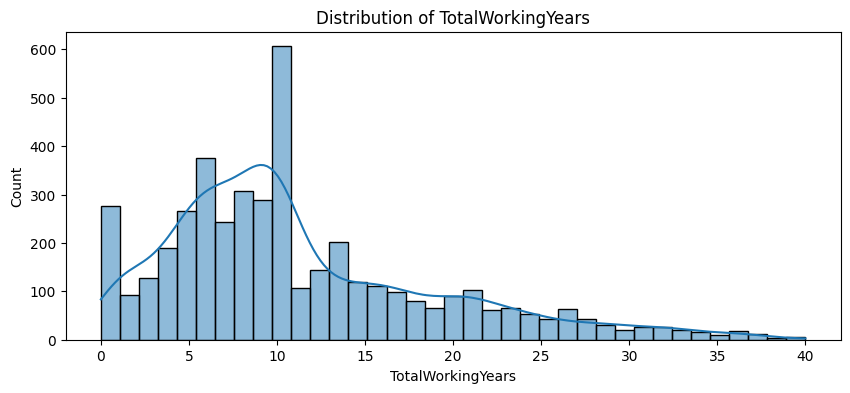

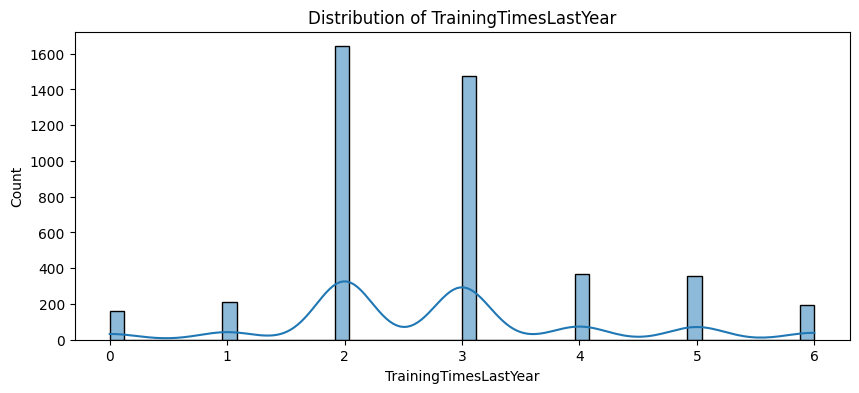

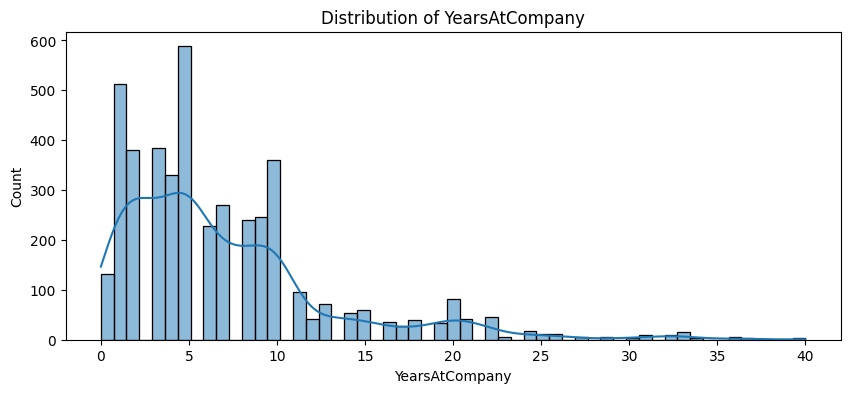

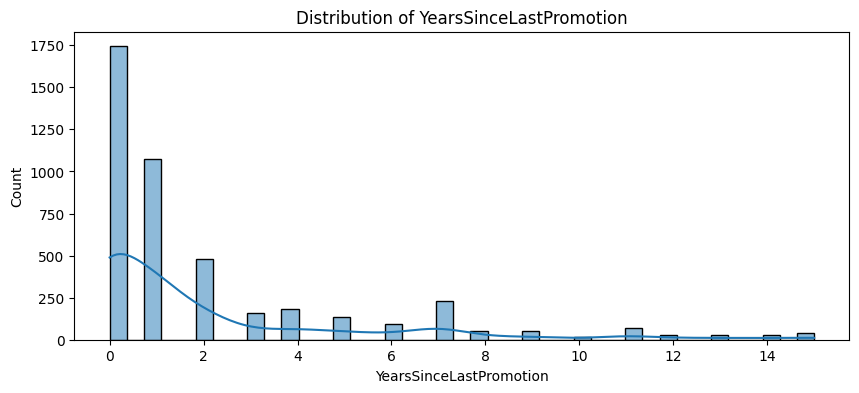

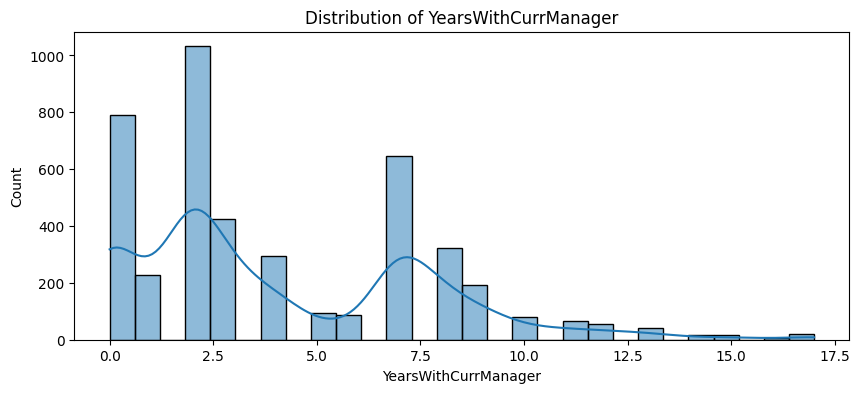

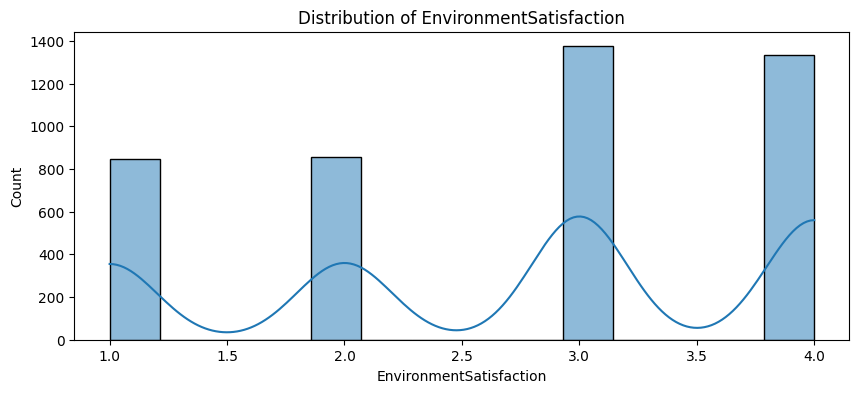

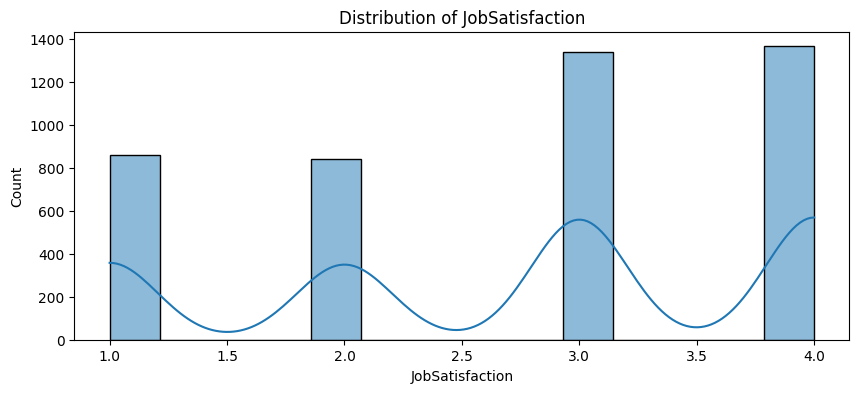

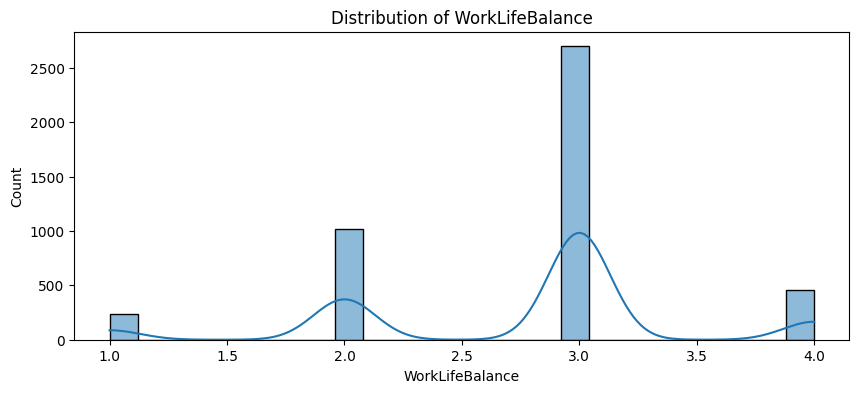

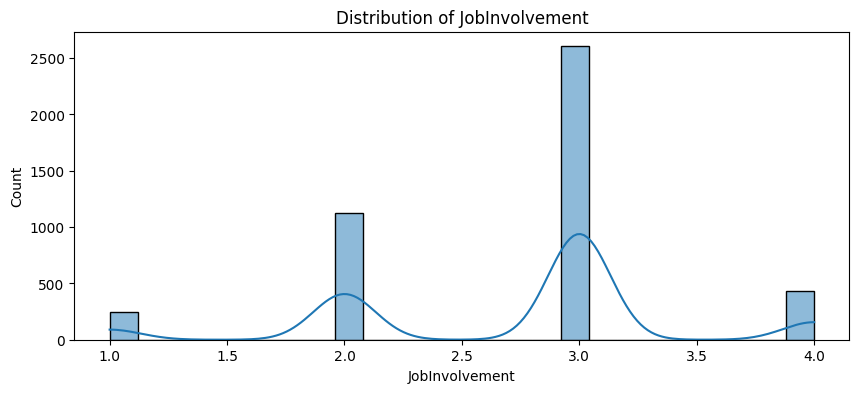

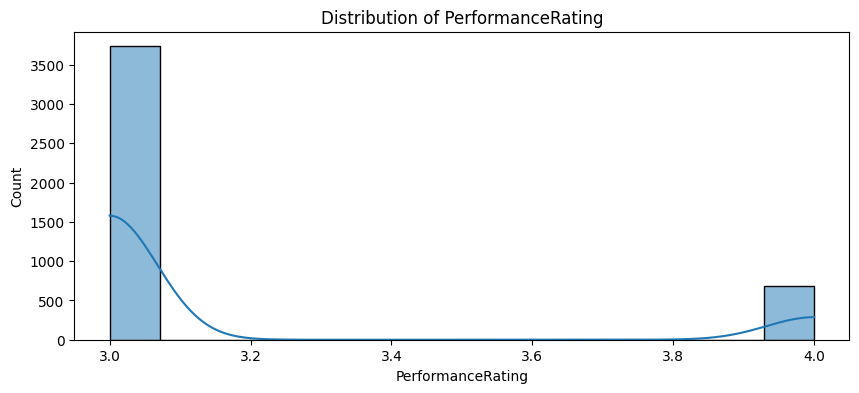

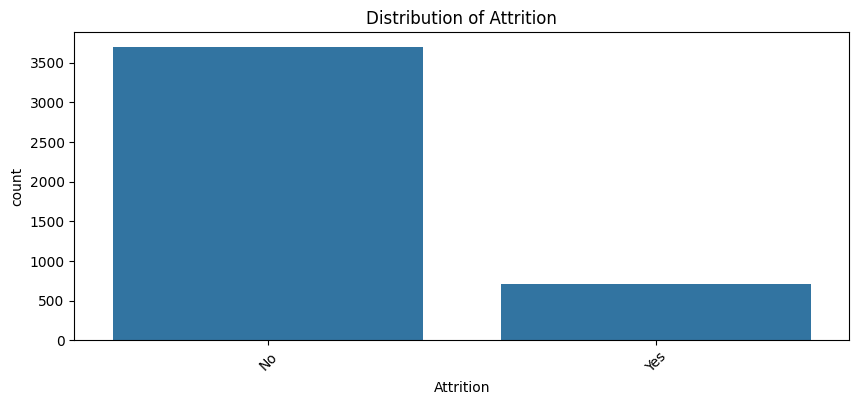

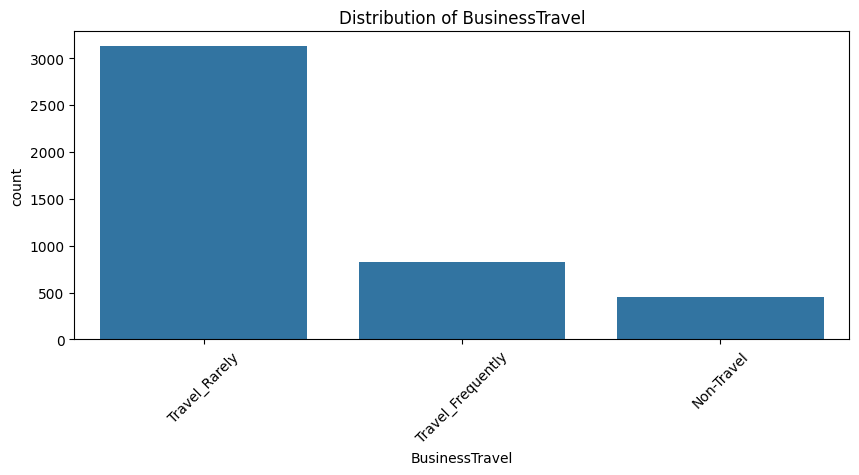

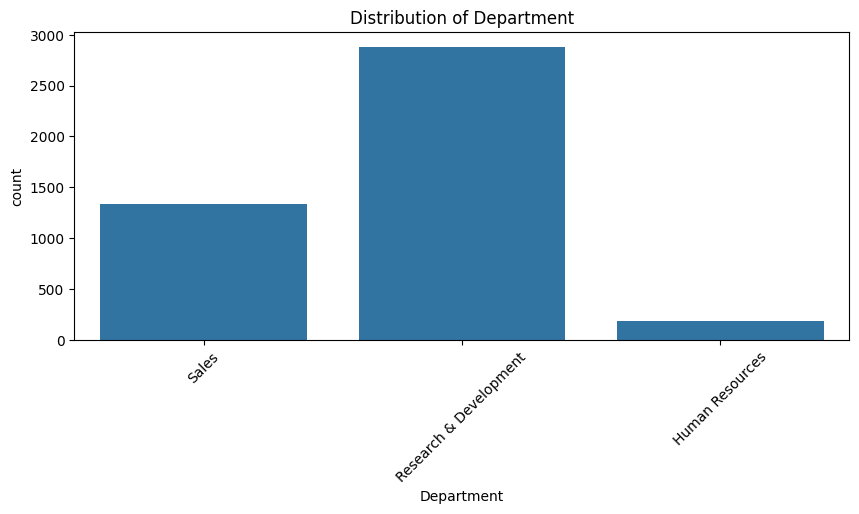

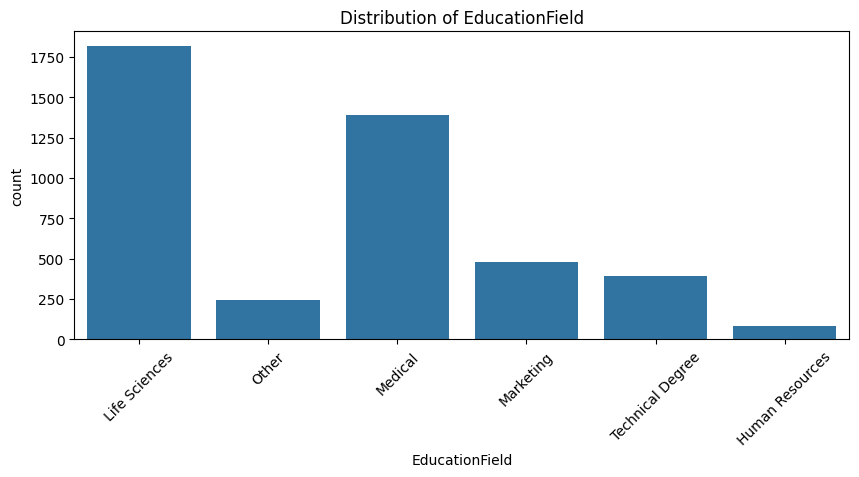

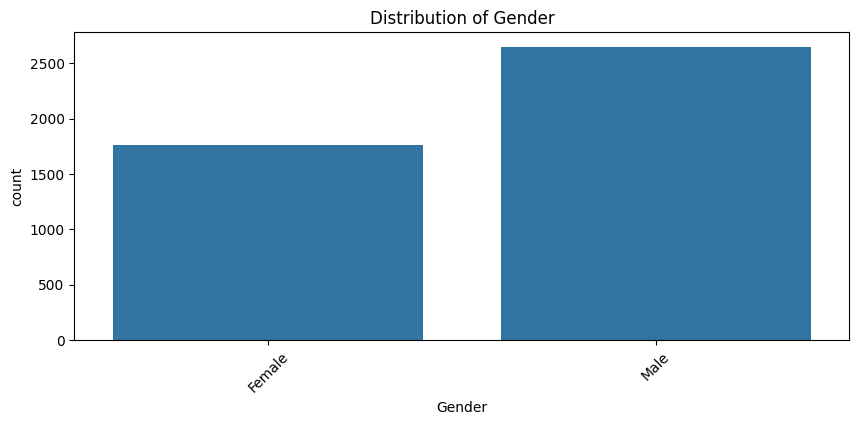

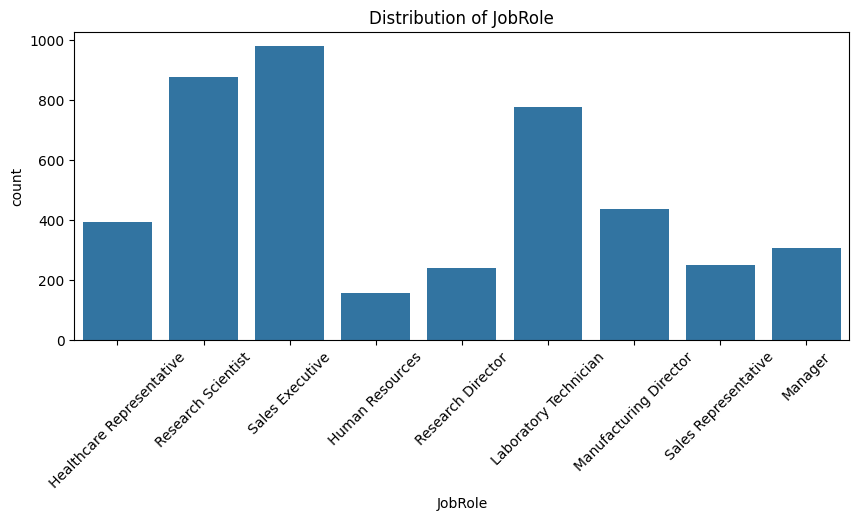

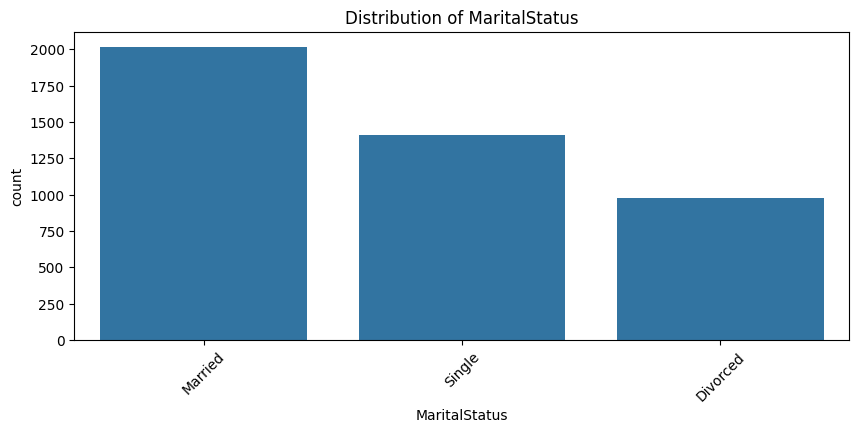

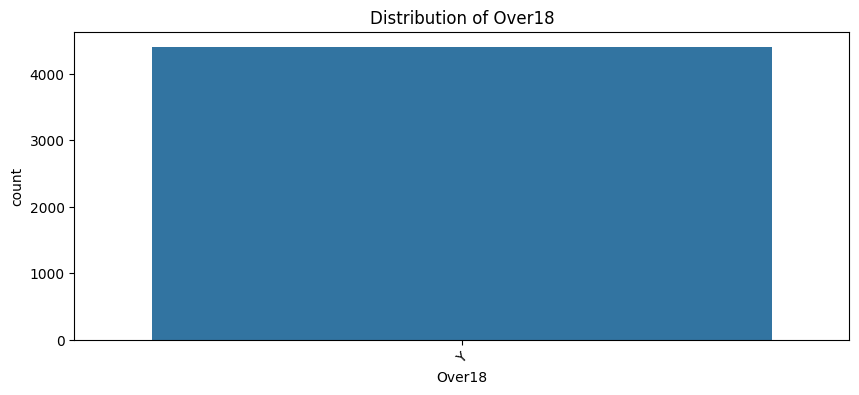

In [7]:
# Analyse univariée pour les colonnes numériques
for column in numerical_columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(generalData[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

# Analyse univariée pour les colonnes catégoriques
for column in categorical_columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=generalData[column])
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
    plt.show()

# Fusion des CSV InTime et OutTime

In [8]:
# Charger les données
inTime.rename(columns={'Unnamed: 0':'EmployeeID'},inplace=True)
outTime.rename(columns={'Unnamed: 0':'EmployeeID'},inplace=True)
inTime.replace("NA",np.nan,inplace=True)

for col in inTime.columns.array[1::]:
    inTime[col] = pd.to_datetime(inTime[col],format='%Y-%m-%d %H:%M:%S')
for col in outTime.columns.array[1::]:
    outTime[col] = pd.to_datetime(outTime[col],format='%Y-%m-%d %H:%M:%S')
    inTime.dtypes
# refactoriser les inTime et outTime en un seul dataframe avec les colonnes suivantes : employeeID, date, time_diff, entry_time, exit_time, exit_time - entry_time
# Transformer les dataframes inTime et outTime en format long
inTime_melted = inTime.melt(id_vars=['EmployeeID'], var_name='Date', value_name='Entry_Time')
outTime_melted = outTime.melt(id_vars=['EmployeeID'], var_name='Date', value_name='Exit_Time')

# Fusionner les dataframes sur EmployeeID et Date
merged_times = pd.merge(inTime_melted, outTime_melted, on=['EmployeeID', 'Date'])
merged_times.dropna(inplace=True)

# Calculer la différence de temps
merged_times['Worktime'] = merged_times['Exit_Time'] - merged_times['Entry_Time']

# Reordonner les colonnes
times_df = merged_times[['EmployeeID', 'Entry_Time', 'Exit_Time', 'Worktime']]
# Calculer le temps de travail moyen et le nombre de jours travaillés par employé
worktime_df = times_df.groupby('EmployeeID').agg(MeanWorktime=('Worktime', 'mean'),DaysWorked=('Worktime', 'count')).reset_index()
worktime_df.describe()

EmployeeID               MeanWorktime   DaysWorked
count  4410.000000                       4410  4410.000000
mean   2205.500000  0 days 07:42:02.850424120   236.265306
std    1273.201673  0 days 01:20:24.784576008     5.503779
min       1.000000  0 days 05:57:01.814977973   225.000000
25%    1103.250000  0 days 06:40:23.999167221   232.000000
50%    2205.500000  0 days 07:24:24.337947974   236.000000
75%    3307.750000  0 days 08:22:07.329191312   241.000000
max    4410.000000  0 days 11:01:51.457264957   248.000000

# Fusion de tous les CSV

In [20]:
allDataSet = generalData.merge(worktime_df, on=['EmployeeID'], how='outer')
allDataSet.head()

Age Attrition     BusinessTravel              Department  DistanceFromHome  \
0   51        No      Travel_Rarely                   Sales                 6   
1   31       Yes  Travel_Frequently  Research & Development                10   
2   32        No  Travel_Frequently  Research & Development                17   
3   38        No         Non-Travel  Research & Development                 2   
4   32        No      Travel_Rarely  Research & Development                10   

   Education EducationField  EmployeeCount  EmployeeID  Gender  ...  \
0          2  Life Sciences              1           1  Female  ...   
1          1  Life Sciences              1           2  Female  ...   
2          4          Other              1           3    Male  ...   
3          5  Life Sciences              1           4    Male  ...   
4          1        Medical              1           5    Male  ...   

   YearsAtCompany YearsSinceLastPromotion YearsWithCurrManager  \
0               1                       0                    0   
1               5                       1                    4   
2               5                       0                    3   
3               8                       7                    5   
4               6                       0                    4   

   EnvironmentSatisfaction  JobSatisfaction WorkLifeBalance  JobInvolvement  \
0                      3.0              4.0             2.0               3   
1                      3.0              2.0             4.0               2   
2                      2.0              2.0             1.0               3   
3                      4.0              4.0             3.0               2   
4                      4.0              1.0             3.0               3   

   PerformanceRating              MeanWorktime  DaysWorked  
0                  3 0 days 07:22:25.142241379         232  
1                  4 0 days 07:43:08.288135593         236  
2                  3 0 days 07:00:47.665289256         242  
3                  3 0 days 07:11:37.242553191         235  
4                  3 0 days 08:00:22.228571428         245  

[5 rows x 31 columns]

# Nettoyage des données en respectant l'éthique et la RGPD

In [19]:
cleanDataSet = allDataSet
# Arrondir les valeurs de 'Age', 'MeanWorktime' et 'DaysWorked'
cleanDataSet['Age'] = cleanDataSet['Age'].apply(lambda x: round(x / 5) * 5)
cleanDataSet['MeanWorktime'] = cleanDataSet['MeanWorktime'].apply(
    lambda x: (
    datetime.strptime(str(x).split(" ")[-1].split(".")[0], '%H:%M:%S')  # Analyse de l'heure et des secondes
    - timedelta(minutes=(datetime.strptime(str(x).split(" ")[-1].split(".")[0], '%H:%M:%S').minute % 15))  # Arrondir à la quinzaine
    ).strftime('%H:%M')
)
cleanDataSet['DaysWorked'] = cleanDataSet['DaysWorked'].apply(lambda x: round(x / 5) * 5)
# Création de la nouvelle colonne 'Meritocracy' qui est le rapport entre 'PerformanceRating' et 'PercentSalaryHike'
cleanDataSet['Meritocracy'] = cleanDataSet['PerformanceRating'] / cleanDataSet['PercentSalaryHike']


ValueError: time data '07:15' does not match format '%H:%M:%S'

# Analyse Bivariée

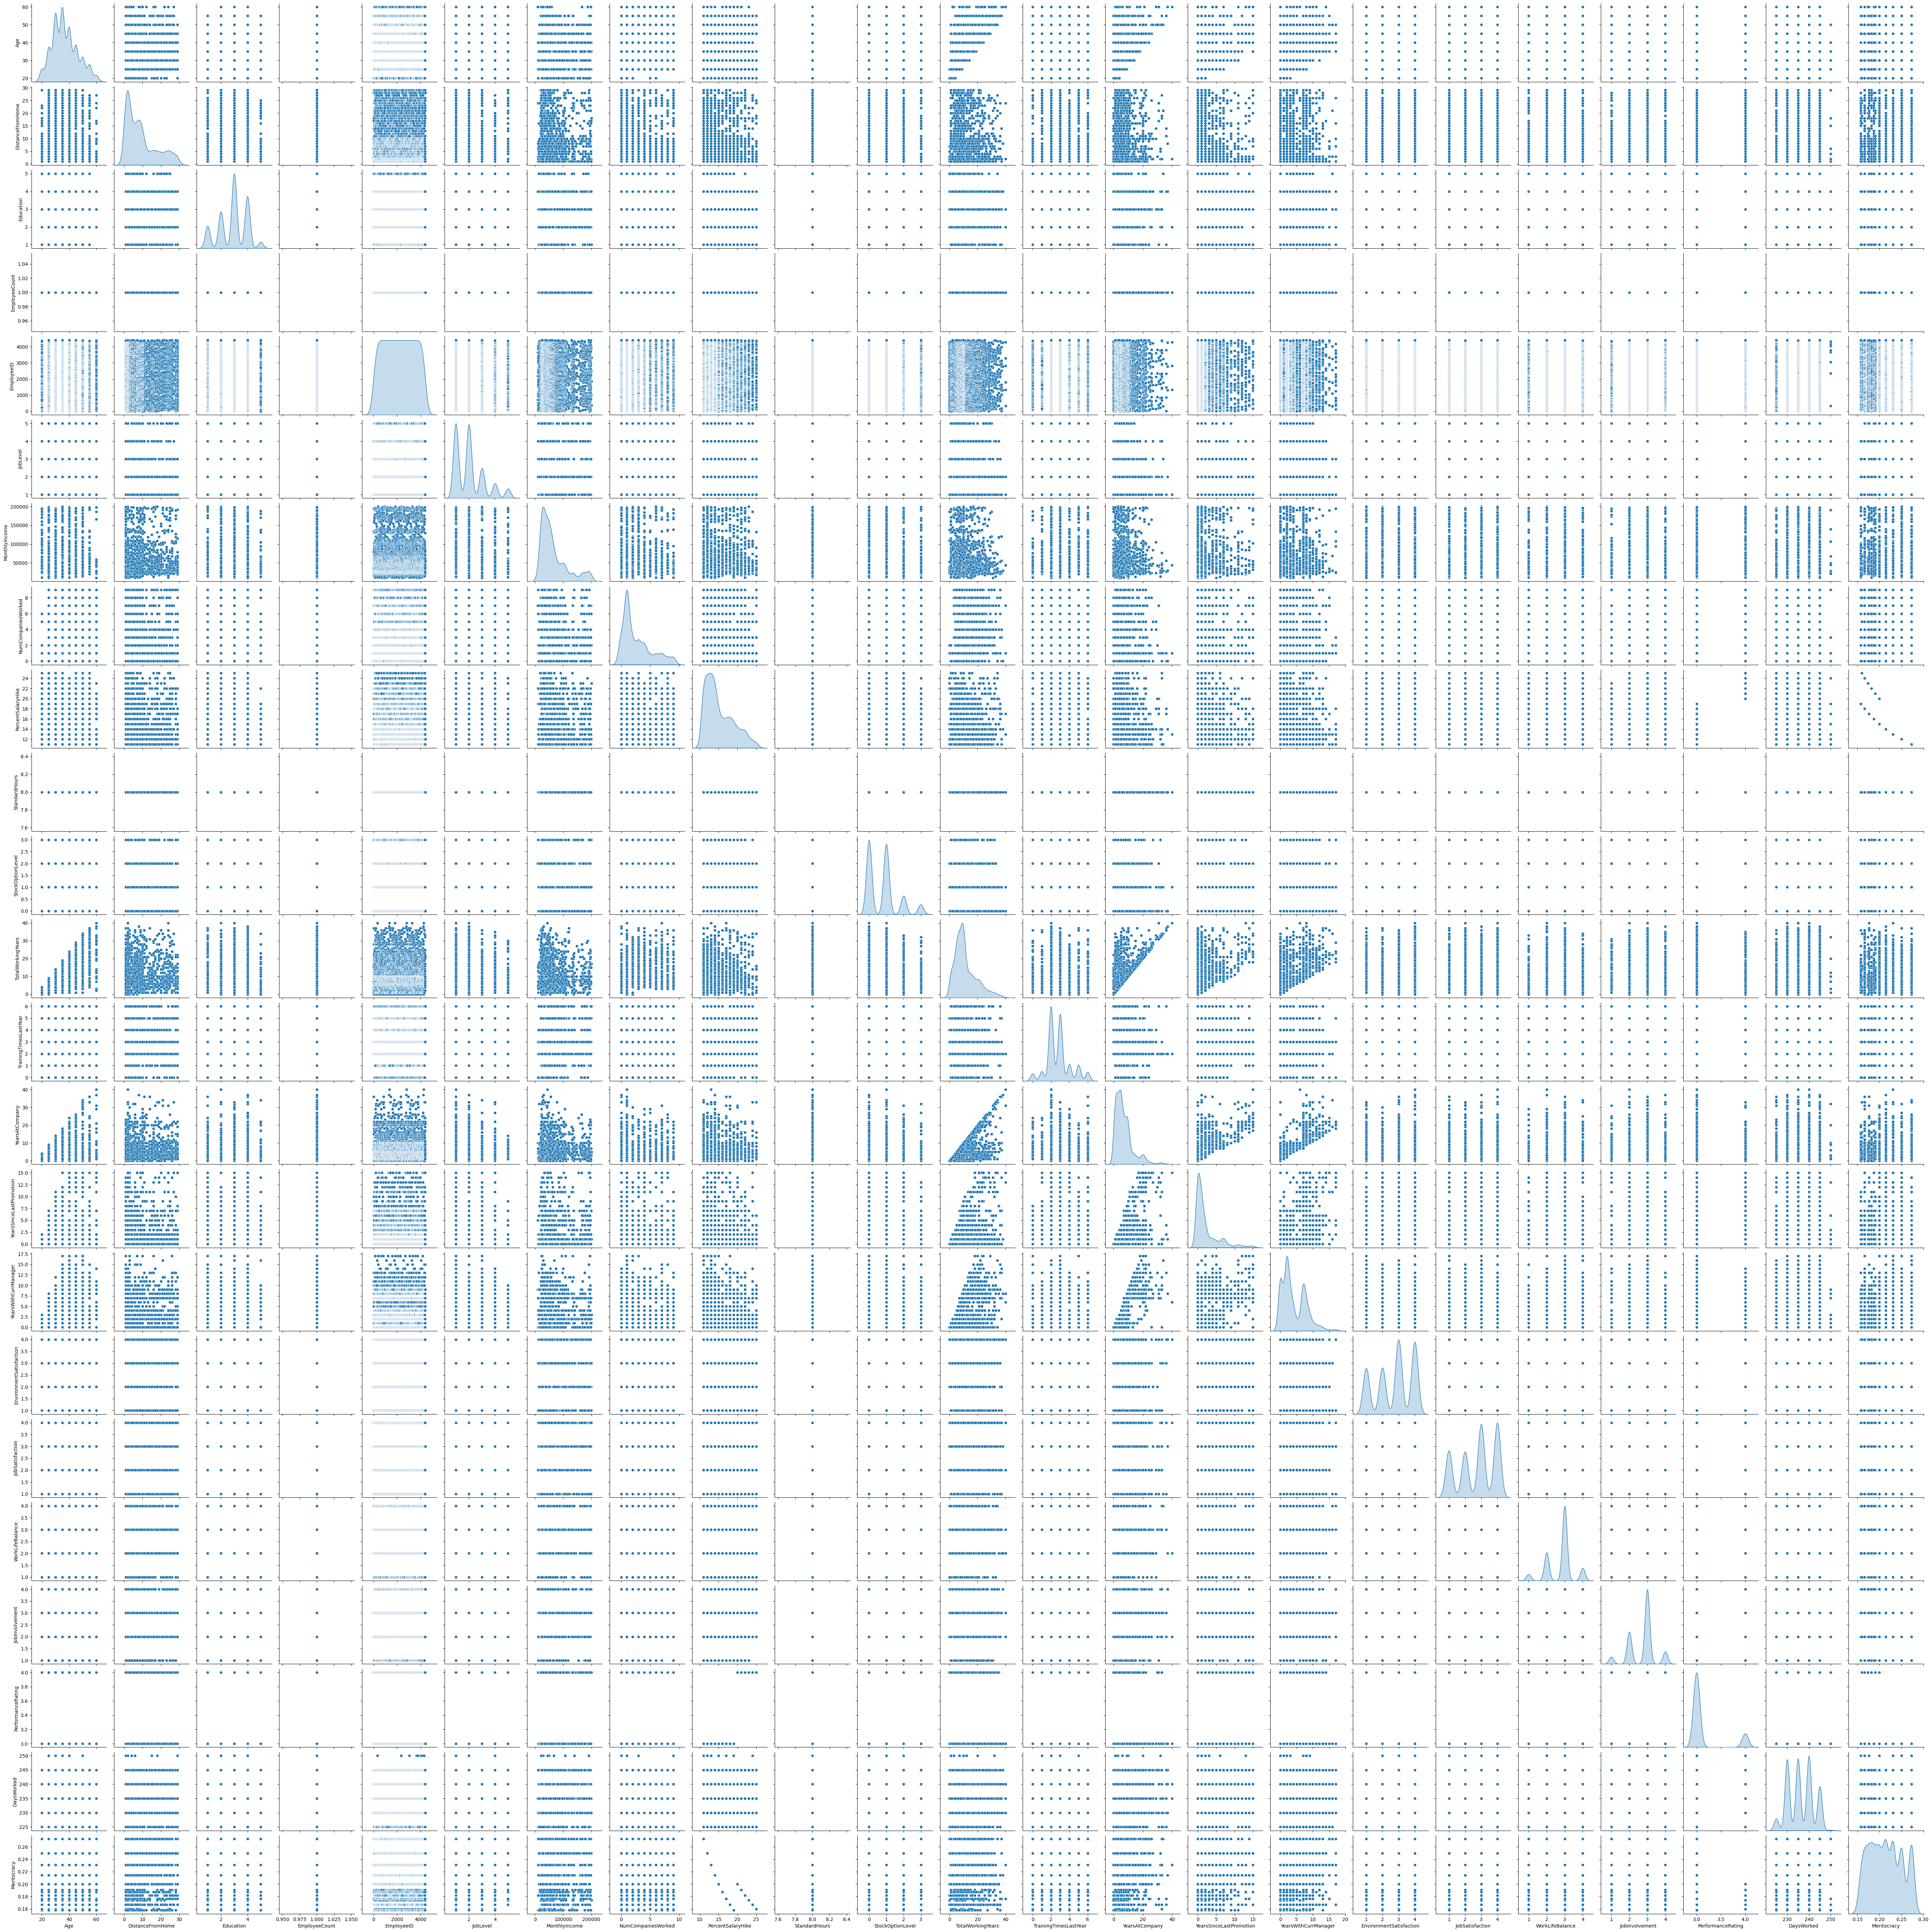

In [11]:
sns.pairplot(cleanDataSet, diag_kind='kde')
plt.show()

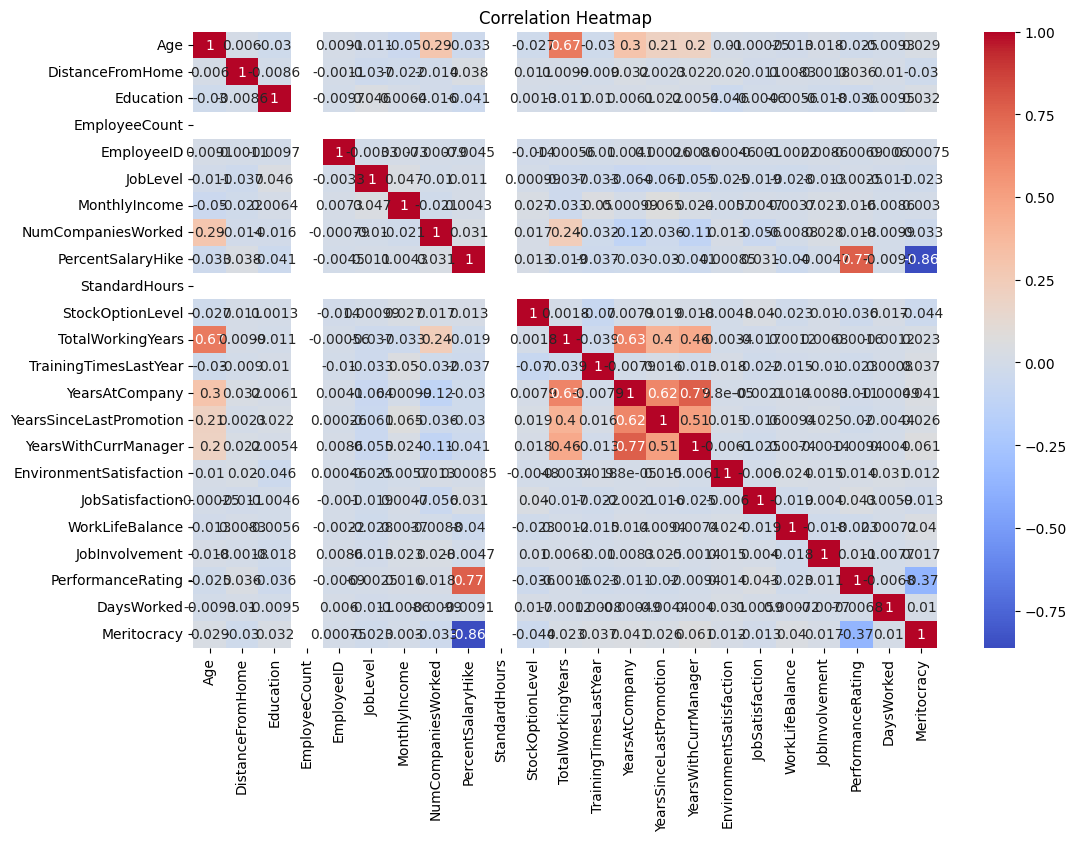

In [21]:
plt.figure(figsize=(12, 8))
sns.heatmap(cleanDataSet[numerical_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

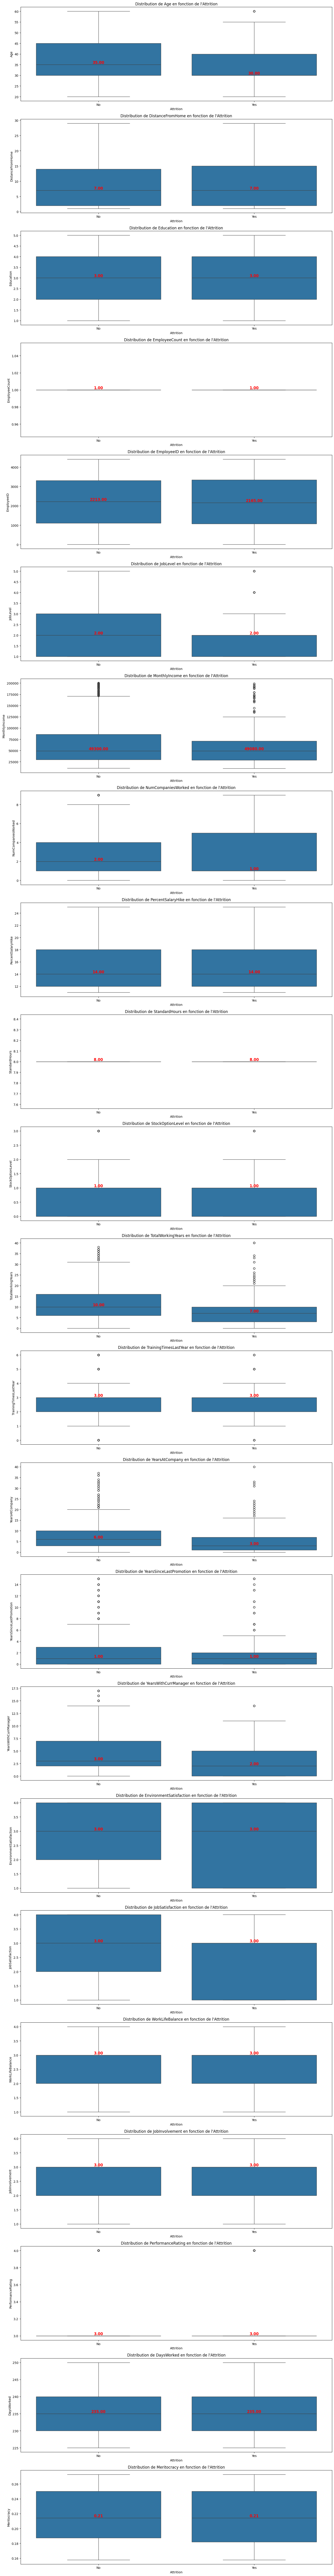

In [12]:
# Sélectionner uniquement les colonnes numériques
numerical_columns = cleanDataSet.select_dtypes(include=['number']).columns

plt.figure(figsize=(15, len(numerical_columns) * 5))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, i)
    sns.boxplot(x='Attrition', y=col, data=cleanDataSet)
    
    # Ajouter les médianes pour comparer l'écart entre Oui/Non
    median_values = cleanDataSet.groupby("Attrition")[col].median()
    for j, attrition_value in enumerate(median_values.index):
        plt.text(j, median_values[attrition_value], f"{median_values[attrition_value]:.2f}", 
                 ha='center', va='bottom', fontsize=12, fontweight='bold', color='red')

    plt.title(f"Distribution de {col} en fonction de l'Attrition")

plt.tight_layout()
plt.show()


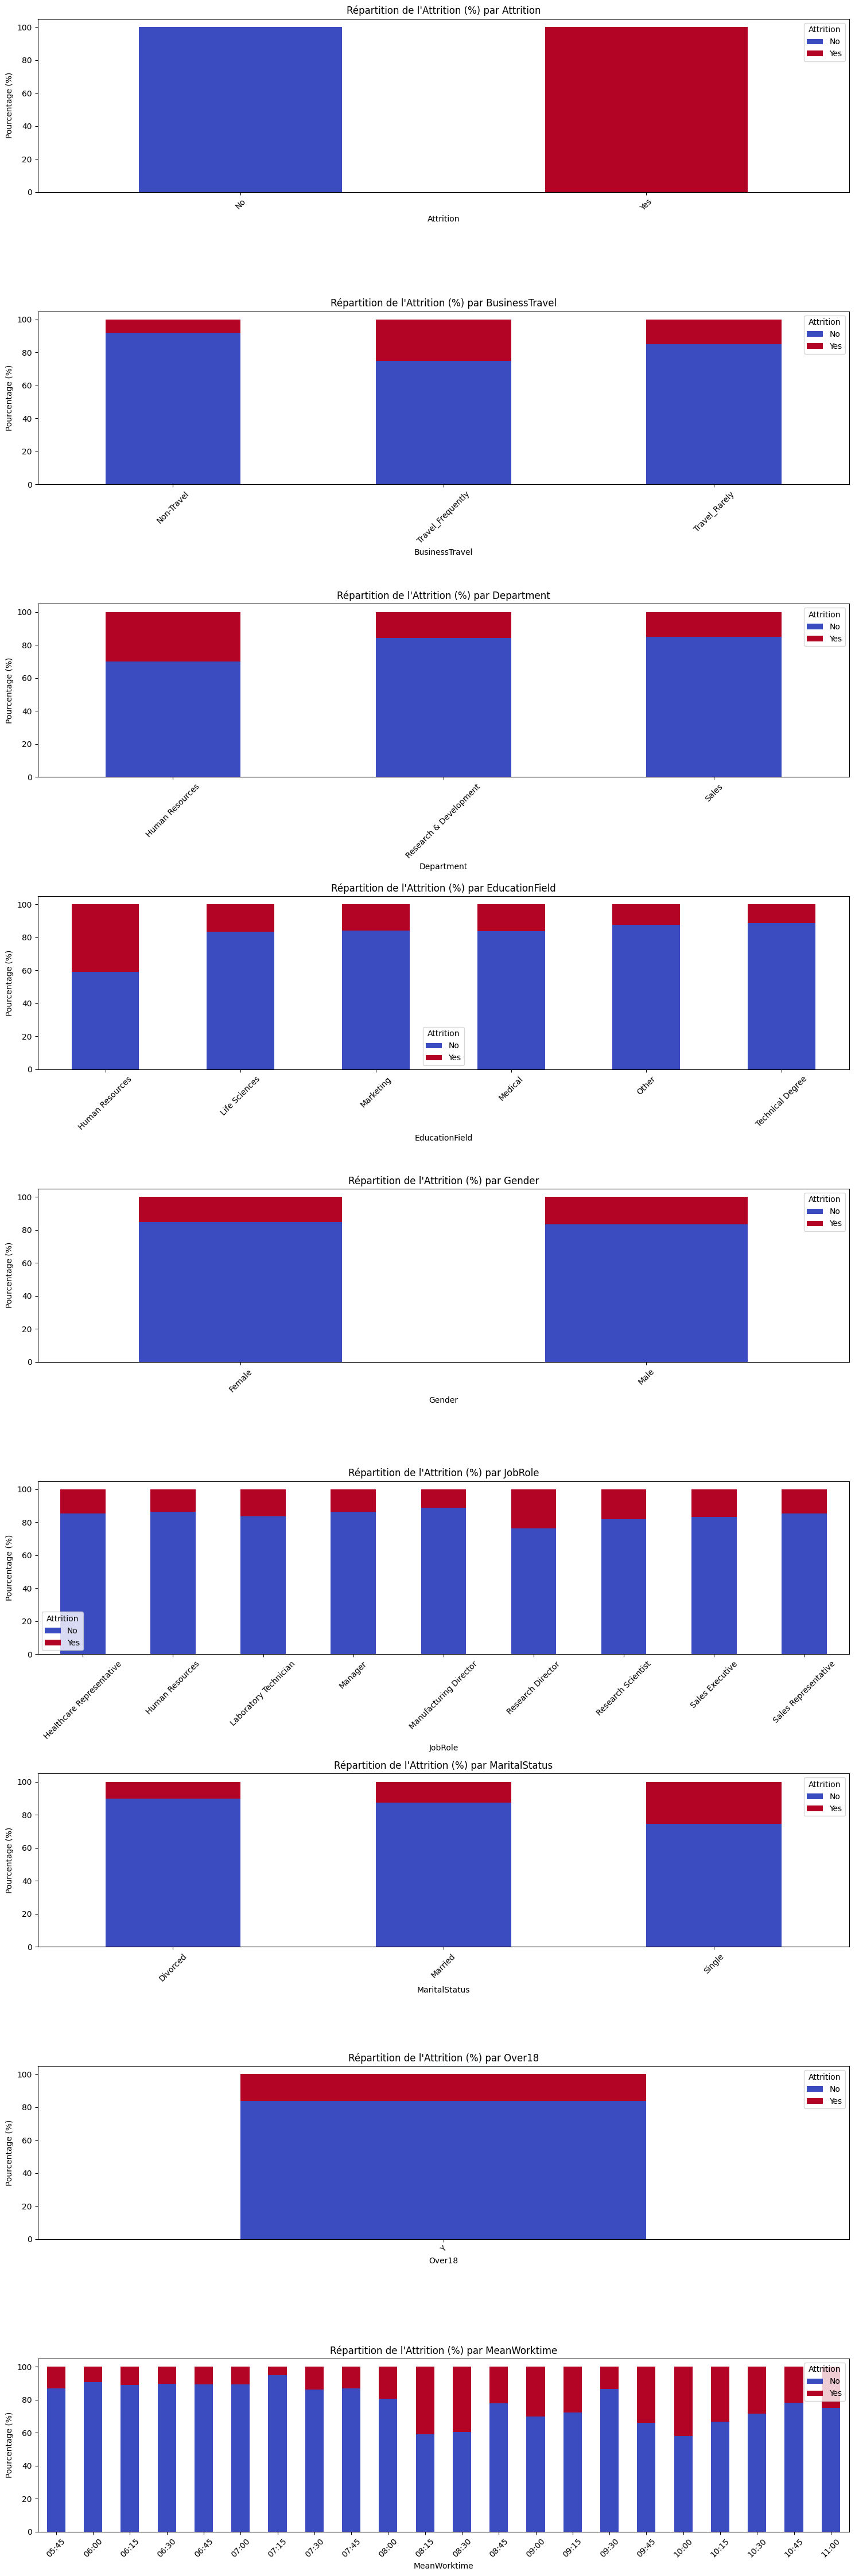

In [13]:
categorical_columns = cleanDataSet.select_dtypes(include=['object']).columns

plt.figure(figsize=(15, len(categorical_columns) * 5))

for i, col in enumerate(categorical_columns, 1):
    plt.subplot(len(categorical_columns), 1, i)
    
    # Calcul du pourcentage d'attrition par catégorie
    category_percent = pd.crosstab(cleanDataSet[col], cleanDataSet['Attrition'], normalize='index') * 100
    # Création du barplot empilé
    category_percent.plot(kind='bar', stacked=True, ax=plt.gca(), colormap="coolwarm")
    
    plt.ylabel("Pourcentage (%)")
    plt.title(f"Répartition de l'Attrition (%) par {col}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [14]:
# Supprimer les colonnes 'EmployeeID', 'Gender', 'Over18','PerformanceRating', 'PercentSalaryHike'
cleanDataSet = cleanDataSet.drop(columns=['EmployeeID', 'Gender', 'Over18','PerformanceRating', 'PercentSalaryHike'])
exportDataCSV(cleanDataSet)

Fichier CSV enregistré : c:\dev\IA\ProjetIA\dataClean.csv
